<a href="https://colab.research.google.com/github/Suj93s/Intel-Unnati/blob/main/Intel_Unnati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/GOPRO
!wget -O GOPRO_Large.zip "https://www.dropbox.com/s/u842yorwmap7xij/GOPRO_Large.zip?dl=1"
!unzip -q GOPRO_Large.zip -d /content/GOPRO
!ls /content/GOPRO/GOPRO_Large

--2025-07-02 07:46:47--  https://www.dropbox.com/s/u842yorwmap7xij/GOPRO_Large.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/bjcw1o6ukodkr7d9frcfi/GOPRO_Large.zip?rlkey=kvs7dicujsnzqdvl972r7xp0c&dl=1 [following]
--2025-07-02 07:46:48--  https://www.dropbox.com/scl/fi/bjcw1o6ukodkr7d9frcfi/GOPRO_Large.zip?rlkey=kvs7dicujsnzqdvl972r7xp0c&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc269a8427518a5e734fa8dcebf4.dl.dropboxusercontent.com/cd/0/inline/Csvo4Tj2DmFAO5Avu7ZOAtC7huzFnxI0uKBhyU5P49VCICNpg6Ix88LRNo1ZGkAZS5p6TQPSIPnnkMrxXi9WEei0_sLTyF-IcOJVfI3Sqh5uS0X6lOU6_H8sAvIivDtpmdLSvwosLfsQ5_HmdaMIqU4P/file?dl=1# [following]
--2025-07-02 07:46:48--  https://uc269a8427518a5e734fa8dcebf4.dl.dropbox

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFilter
import numpy as np
import os
import random
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class UNetDeblur(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU())
        self.res = nn.Sequential(*[ResidualBlock(128) for _ in range(4)])
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU())
        self.out = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        r = self.res(e2)
        d = self.dec1(r)
        out = self.out(d)
        return torch.sigmoid(out)

In [ ]:
class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.pairs = []
        self.transform = transform
        self.augment = augment

        for scene in os.listdir(root_dir):
            blur_folder = os.path.join(root_dir, scene, "blur")
            sharp_folder = os.path.join(root_dir, scene, "sharp")
            if not os.path.isdir(blur_folder):
                continue
            for img_name in os.listdir(blur_folder):
                self.pairs.append((
                    os.path.join(sharp_folder, img_name),
                    os.path.join(sharp_folder, img_name)  # sharp used for blur generation
                ))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sharp_path, _ = self.pairs[idx]
        sharp = Image.open(sharp_path).convert("RGB").resize((256, 256))

        blurred = sharp.filter(ImageFilter.GaussianBlur(radius=1.5))

        if self.augment:
            if random.random() > 0.5:
                sharp = sharp.transpose(Image.FLIP_LEFT_RIGHT)
                blurred = blurred.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform:
            sharp = self.transform(sharp)
            blurred = self.transform(blurred)

        return blurred, sharp

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])


In [ ]:
dataset = GoProDataset("GOPRO/train", transform=transform, augment=True)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetDeblur().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)


In [ ]:
evice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetDeblur().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

for epoch in range(80):
    model.train()
    epoch_loss = 0
    for blurred, sharp in dataloader:
        blurred, sharp = blurred.to(device), sharp.to(device)
        optimizer.zero_grad()
        pred = model(blurred)
        loss = F.l1_loss(pred, sharp) + 0.5 * (1 - ssim(pred.detach().cpu().numpy(), sharp.detach().cpu().numpy(), data_range=1.0, channel_axis=1).mean())

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}")

Epoch 1, Loss: 0.1640
Epoch 2, Loss: 0.0683
Epoch 3, Loss: 0.0517
Epoch 4, Loss: 0.0441
Epoch 5, Loss: 0.0402
Epoch 6, Loss: 0.0377
Epoch 7, Loss: 0.0363
Epoch 8, Loss: 0.0343
Epoch 9, Loss: 0.0341
Epoch 10, Loss: 0.0324
Epoch 11, Loss: 0.0319
Epoch 12, Loss: 0.0311
Epoch 13, Loss: 0.0309
Epoch 14, Loss: 0.0300
Epoch 15, Loss: 0.0299
Epoch 16, Loss: 0.0292
Epoch 17, Loss: 0.0289
Epoch 18, Loss: 0.0281
Epoch 19, Loss: 0.0278
Epoch 20, Loss: 0.0277
Epoch 21, Loss: 0.0272
Epoch 22, Loss: 0.0269
Epoch 23, Loss: 0.0269
Epoch 24, Loss: 0.0270
Epoch 25, Loss: 0.0266
Epoch 26, Loss: 0.0260
Epoch 27, Loss: 0.0263
Epoch 28, Loss: 0.0263
Epoch 29, Loss: 0.0257
Epoch 30, Loss: 0.0257
Epoch 31, Loss: 0.0256
Epoch 32, Loss: 0.0254
Epoch 33, Loss: 0.0250
Epoch 34, Loss: 0.0250
Epoch 35, Loss: 0.0249
Epoch 36, Loss: 0.0248
Epoch 37, Loss: 0.0250
Epoch 38, Loss: 0.0246
Epoch 39, Loss: 0.0244
Epoch 40, Loss: 0.0246
Epoch 41, Loss: 0.0241
Epoch 42, Loss: 0.0242
Epoch 43, Loss: 0.0243
Epoch 44, Loss: 0.02

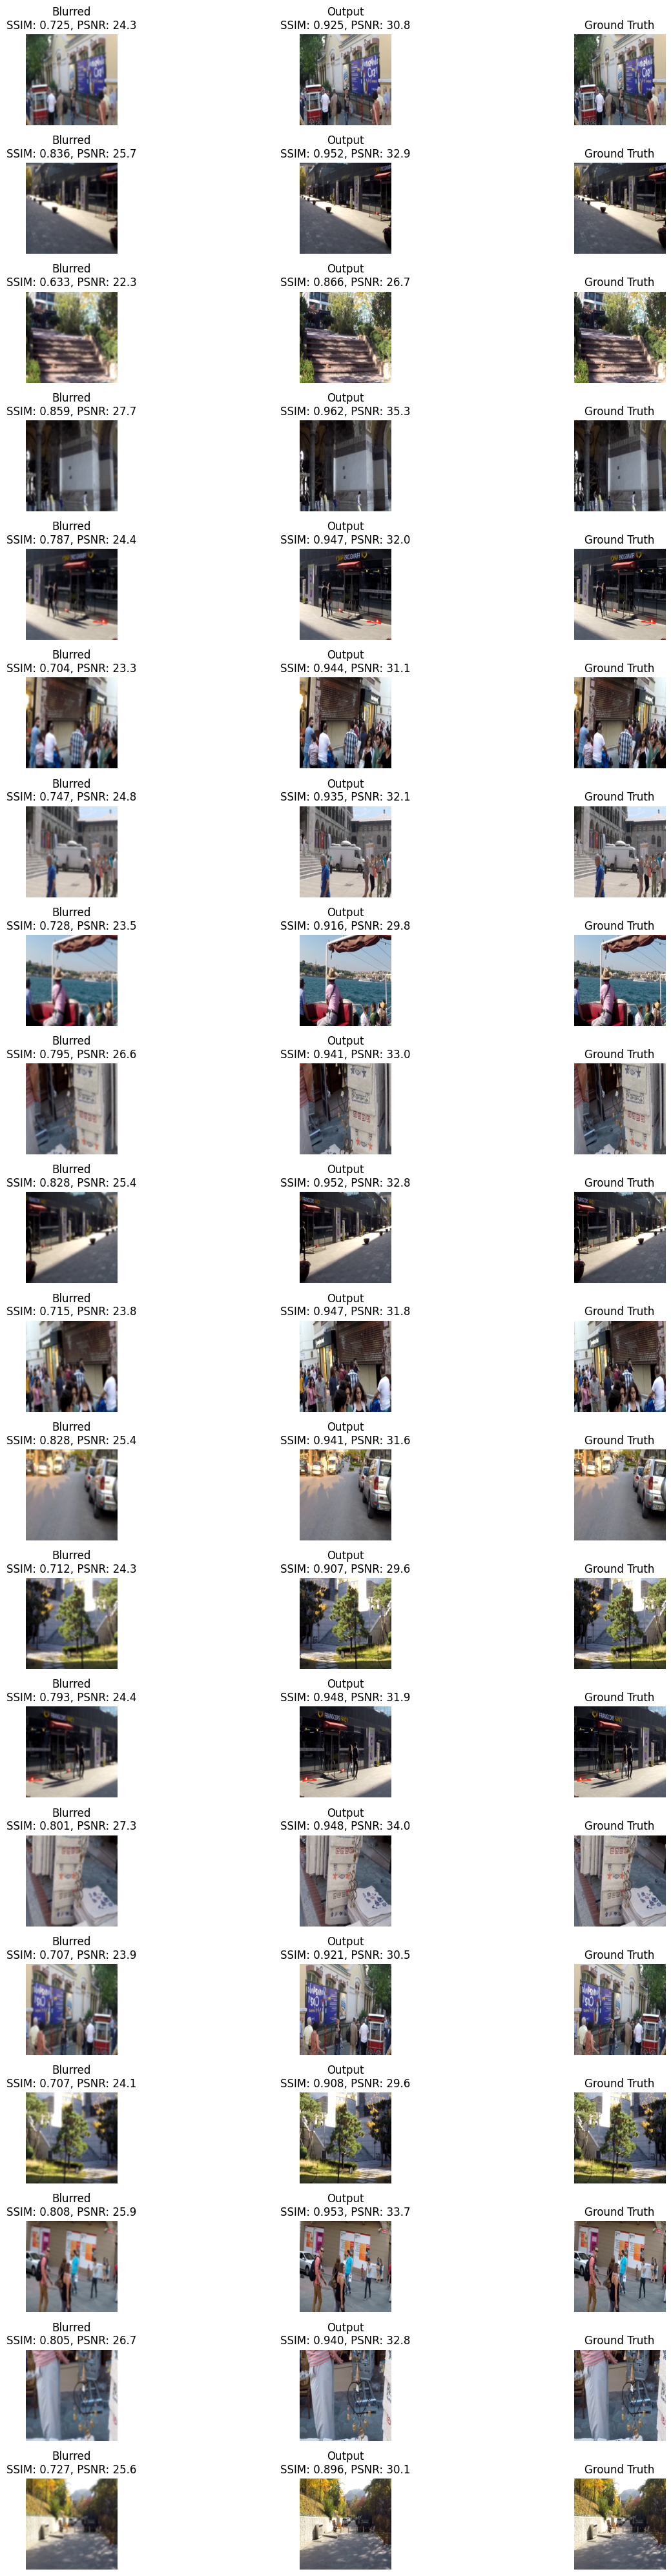


📊 Average over 20 samples:
Blurred Input  - SSIM: 0.7622, PSNR: 24.98
Model Output   - SSIM: 0.9325, PSNR: 31.61


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim_fn
from skimage.metrics import peak_signal_noise_ratio as psnr_fn

def visualize_and_evaluate(model, dataset, device, count=20):
    model.eval()
    total_ssim_blur, total_psnr_blur = 0, 0
    total_ssim_pred, total_psnr_pred = 0, 0

    fig, axes = plt.subplots(count, 3, figsize=(15, count * 2))
    indices = np.random.choice(len(dataset), count, replace=False)

    for i, idx in enumerate(indices):
        blurred, sharp = dataset[idx]
        input_tensor = blurred.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(input_tensor).squeeze(0).cpu().numpy()

        blur_np = np.transpose(blurred.numpy(), (1, 2, 0))
        sharp_np = np.transpose(sharp.numpy(), (1, 2, 0))
        pred_np = np.transpose(pred, (1, 2, 0))

        # Clip values to [0, 1]
        blur_np = np.clip(blur_np, 0, 1)
        sharp_np = np.clip(sharp_np, 0, 1)
        pred_np = np.clip(pred_np, 0, 1)

        # Metrics (handle small images with win_size=5)
        ssim_blur = ssim_fn(sharp_np, blur_np, data_range=1.0, channel_axis=2, win_size=5)
        psnr_blur = psnr_fn(sharp_np, blur_np, data_range=1.0)

        ssim_pred = ssim_fn(sharp_np, pred_np, data_range=1.0, channel_axis=2, win_size=5)
        psnr_pred = psnr_fn(sharp_np, pred_np, data_range=1.0)

        total_ssim_blur += ssim_blur
        total_psnr_blur += psnr_blur
        total_ssim_pred += ssim_pred
        total_psnr_pred += psnr_pred

        # Plotting
        axes[i][0].imshow(blur_np)
        axes[i][0].set_title(f"Blurred\nSSIM: {ssim_blur:.3f}, PSNR: {psnr_blur:.1f}")
        axes[i][0].axis("off")

        axes[i][1].imshow(pred_np)
        axes[i][1].set_title(f"Output\nSSIM: {ssim_pred:.3f}, PSNR: {psnr_pred:.1f}")
        axes[i][1].axis("off")

        axes[i][2].imshow(sharp_np)
        axes[i][2].set_title("Ground Truth")
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.show()

    print("\n📊 Average over 20 samples:")
    print(f"Blurred Input  - SSIM: {total_ssim_blur / count:.4f}, PSNR: {total_psnr_blur / count:.2f}")
    print(f"Model Output   - SSIM: {total_ssim_pred / count:.4f}, PSNR: {total_psnr_pred / count:.2f}")
visualize_and_evaluate(model=model, dataset=dataset, device=device, count=20)

